# Welcome to GoNB

[*GoNB*](https://github.com/janpfeifer/gonb) is a *Go* notebook kernel. It allows one to easily run *Go* code in a *Jupyter Notebook* and variations.

In this tutorial we will walk through most of its features, and explain how it works.

See the [README.md's Installation section](https://github.com/janpfeifer/gonb#installation). It also includes a Docker with Jupyter+GoNB pre-installed, that makes it trivial.

## Hello World!

Whenever a cell is executed, *gonb* saves the cell content of the cell to a *Go* file, auto-imports missing dependencies (when it can guess), compiles and runs it. It may seem a lot, but its pretty fast (except
maybe the first cell run that is usually a little slower) and feels interactive. 

In [2]:
func main() {
    fmt.Printf("Hello World!")
}

Hello World!

Easy, right ? Now when trying different things, to avoid having to write `func main()` at every cell, *gonb* provides a short cut: "%%". Anything after a "%%" will be wrapped inside a `func main() { ... }`.

So, let's redo our example above:

In [3]:
%%
fmt.Printf("Hello World!")

Hello World!

## Globals and Updates

Imports, functions, constants, types and variables global declarations are memorized once executed, and carry over from one cell to another.

So one can work on different functions let's say on different cells.

Let's test it out:

In [4]:
func incr[T interface{constraints.Float|constraints.Integer}](x T) T {
    return x+T(1)
}

Ok, now we have `incr` defined to any numeric type, we can use it in all our future cells.

Some quick tests:

In [5]:
%%
x := incr(1)
y := incr(math.Pi)
fmt.Printf("incr: x=%d, y=%f\n", x, y)

incr: x=2, y=4.141593


> **Note**: Only the various declarations are carried over from one cell to another, not the results of the execution, including updates to variables.
> 
> So for instance, if we initialize a variable `startValue` with 1, then increment it in one cell. Next time we execute a new cell, it will be again initialized to 1. 

In [6]:
var startValue = float32(1)

%%
startValue = incr(startValue)
fmt.Printf("current startValue=%f\n", startValue)

current startValue=2.000000


Now if we execute again, `startValue` is again initialized to 1:

In [7]:
%%
fmt.Printf("current startValue=%f\n", startValue)

current startValue=1.000000


If one wants to save results calculated from one cell to another, GoNB includes the `github.com/janpfeifer/gonb/cache` package that makes it trivial to save and load previously generated results.

**Example**: Below `VeryExpensive` is only called once for `CachedValue`, so you will notice that if you run the cell multiple times, it will display always the same number, while `NonCachedValue` will always call `VeryExpensive` again, and display another number. So the string "...calculating..." is printed twice only the first time.

In [8]:
// Temporary fix until new release v0.6.0 propagates.
import (
    "math/rand"
    "github.com/janpfeifer/gonb/cache"
)

func VeryExpensive() int {
    fmt.Println("\t...VeryExpensive() call...")
    return rand.Intn(1000)
}

var (
    CachedValue = cache.Cache("expensive", VeryExpensive)
    NonCachedValue = VeryExpensive()
)
    
%%
fmt.Printf("NonCachedValue=%d\n", NonCachedValue)
fmt.Printf("   CachedValue=%d\n", CachedValue)

	...VeryExpensive() call...
NonCachedValue=723
   CachedValue=446


The `cache` package has many more features, check out [its documentation](https://pkg.go.dev/github.com/janpfeifer/gonb/cache).

Now, we don't want to have `NonCachedValue` execute `VeryExpensive` at every cell, so let's remove its definition.
See how to manage memorized definitions using `%help`, in the "Managing Memorized Definitions" section, it's displayed at the end of the tutorial.

In [9]:
%rm NonCachedValue CachedValue

. removed var NonCachedValue
. removed var CachedValue


## Imports

A few things to remember from imports in *gonb*:

* Like all other global declarations, they are memorized and carry over from one cell to the other. Still it's good practice to have each cell import what it needs -- no harm in importing the same thing multiple times.
* *gonb* runs *goimports* before compiling the code: that means it will be able to automatically add import statements for builtin packages (in the examples above we never wrote `import "fmt"`, and it just worked).
* *gonb* runs `go get` before compiling the code. This automatically fetches an external import dependency. That is convenient in most cases, but in case you want to get an external *Go* module at an specific version, you can do it manually with something like `!*go get <github.com/user/my_go_module>@<my_version>`. See below on running shell commands.

Let's create a simple example that imports a delighful progress-bar library. Notice it automatically fetches the lastest version of the library `github.com/schollz/progressbar/v3` -- and the execution of the cell the first time may take a few seconds because of that.


In [10]:
import progressbar "github.com/schollz/progressbar/v3"

%%
bar := progressbar.NewOptions(100, 
                              progressbar.OptionUseANSICodes(true),
                              progressbar.OptionShowIts(),
                              progressbar.OptionSetItsString("steps"))
for i := 0; i < 100; i++ {
    bar.Add(1)
    time.Sleep(40 * time.Millisecond)
}
fmt.Printf("\nDone\n")

 100% |████████████████████████████████████████| (25 steps/s) [3s:0s]s:0s]
Done


## Displaying HTML, Image and others

One of the things that makes working in Notebooks better than using a terminal is that one can display rich content, like dynamically generated images, plots, HTML, even videos and sound.

We'll follow with a few examples of what is already supported.

### Improved Hello World!

*gonb* includes the accompanying library *gonbUI* that handles the interfacing to the Notebook through a very simple API:


In [11]:
import "github.com/janpfeifer/gonb/gonbui"

%%
gonbui.DisplayHtml(`<span style="background:pink; color:#111; border-radius: 3px; border: 3px solid orange; font-size: 18px;">I 🧡 GoNB!</span>`)

I 🧡 GoNB!

### Markdown

Markdown output is also supported -- and used for the `%help` command, see the bottom of the tutorial.

This also renders math formulas using latex, use `$x^2$` for formulas inlined in text, or
`$$x^2$$` for formulas in their own line.

Example:

In [12]:
%%
gonbui.DisplayMarkdown("#### Objective\n\n1. Have fun coding **Go**;\n1. Profit...\n"+
                       `$$f(x) = \int_{-\infty}^{\infty} e^{-x^2} dx$$`)


#### Objective

1. Have fun coding **Go**;
1. Profit...
$$f(x) = \int_{-\infty}^{\infty} e^{-x^2} dx$$

### Fractals

Let's draw a fractal, using another fun package: [github.com/benc-uk/gofract]("github.com/benc-uk/gofract")

lastRenderTime=0.893915


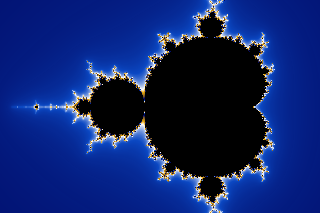

In [13]:
import "github.com/benc-uk/gofract/pkg/fractals"
import "github.com/benc-uk/gofract/pkg/colors"

%%
imgWidth := 320

// Default fractal
f := fractals.Fractal{
    FractType:    "mandelbrot",
    Center:       fractals.ComplexPair{-0.6, 0.0},
    MagFactor:    1.0,
    MaxIter:      90,
    W:            3.0,
    H:            2.0,
    ImgWidth:     imgWidth,
    JuliaSeed:    fractals.ComplexPair{0.355, 0.355},
    InnerColor:   "#000000",
    FullScreen:   false,
    ColorRepeats: 2,
}
gradient := colors.GradientTable{}
gradient.AddToTable("#000762", 0.0)
gradient.AddToTable("#0B48C3", 0.2)
gradient.AddToTable("#ffffff", 0.4)
gradient.AddToTable("#E3A000", 0.5)
gradient.AddToTable("#000762", 0.9)
imgHeight := int(float64(imgWidth) * float64(f.H/f.W))
img := image.NewRGBA(image.Rect(0, 0, f.ImgWidth, imgHeight))
lastRenderTime := f.Render(img, gradient)
fmt.Printf("lastRenderTime=%v\n", lastRenderTime)
gonbui.DisplayImage(img)


### SVG Drawing

From the amazing [SVGo library](https://github.com/ajstarks/svgo), I really wish I was that creative.
Below is Antony Stark's Shining example, [demoed here](https://speakerdeck.com/ajstarks/svgo-code-plus-picture-examples)

In [14]:
import "bytes"
import svgo "github.com/ajstarks/svgo"
import "github.com/janpfeifer/gonb/gonbui"

func Shining(width, height int) string {
    buf := bytes.NewBuffer(nil)
    canvas := svgo.New(buf)
    xp := []int{50, 70, 70, 50, 30, 30}
    yp := []int{40, 50, 75, 85, 75, 50}
    xl := []int{0, 0, 50, 100, 100}
    yl := []int{100, 40, 10, 40, 100}
    bgcolor := "rgb(227,78,25)"
    bkcolor := "rgb(153,29,40)"
    stcolor := "rgb(65,52,44)"
    stwidth := 12
    stylefmt := "stroke:%s;stroke-width:%d;fill:%s"
    canvas.Start(width, height)
    canvas.Def()
    canvas.Gid("unit")
    canvas.Polyline(xl, yl, "fill:none")
    canvas.Polygon(xp, yp)
    canvas.Gend()
    canvas.Gid("runit")
    canvas.TranslateRotate(150, 180, 180)
    canvas.Use(0, 0, "#unit")
    canvas.Gend()
    canvas.Gend()
    canvas.DefEnd()
    canvas.Rect(0, 0, width, height, "fill:"+bgcolor)
    canvas.Gstyle(fmt.Sprintf(stylefmt, stcolor, stwidth, bkcolor))
    for y := 0; y < height; y += 130 {
        for x := -50; x < width; x += 100 {
            canvas.Use(x, y, "#unit")
            canvas.Use(x, y, "#runit")
        }
    } 
    canvas.Gend()
    canvas.End()
    return buf.String()
}

%%
gonbui.DisplaySvg(Shining(500, 500))

<?xml version="1.0"?>
<!-- Generated by SVGo -->

### Plotting with [Margaid (SVG)](https://github.com/erkkah/margaid)

A real pearl!

Since its latest update is not yet "released" (tagged in Git), we needed to get the version on the specific commit. See "Executing Shell Commands" below.

In [15]:
!*go get -u github.com/erkkah/margaid@d60b2efd2f5acc5d8fbbe13eaf85f1532e11a2fb

go: added github.com/erkkah/margaid v0.1.1-0.20230128143048-d60b2efd2f5a


In [16]:
import "bytes"
import "github.com/janpfeifer/gonb/gonbui"
import mg "github.com/erkkah/margaid"

func mgPlot(width, height int) string {
    randomSeries := mg.NewSeries()
    rand.Seed(time.Now().Unix())
    for i := float64(0); i < 10; i++ {
        randomSeries.Add(mg.MakeValue(i+1, 200*rand.Float64()))
    }

    testSeries := mg.NewSeries()
    multiplier := 2.1
    v := 0.33
    for i := float64(0); i < 10; i++ {
        v *= multiplier
        testSeries.Add(mg.MakeValue(i+1, v))
    }

    diagram := mg.New(width, height,
        mg.WithAutorange(mg.XAxis, testSeries),
        mg.WithAutorange(mg.YAxis, testSeries),
        mg.WithAutorange(mg.Y2Axis, testSeries),
        mg.WithProjection(mg.YAxis, mg.Log),
        mg.WithInset(70),
        mg.WithPadding(2),
        mg.WithColorScheme(90),
        mg.WithBackgroundColor("#f8f8f8"),
    )

    diagram.Line(testSeries, mg.UsingAxes(mg.XAxis, mg.YAxis), mg.UsingMarker("square"), mg.UsingStrokeWidth(1))
    diagram.Smooth(testSeries, mg.UsingAxes(mg.XAxis, mg.Y2Axis), mg.UsingStrokeWidth(3.14))
    diagram.Smooth(randomSeries, mg.UsingAxes(mg.XAxis, mg.YAxis), mg.UsingMarker("filled-circle"))
    diagram.Axis(testSeries, mg.XAxis, diagram.ValueTicker('f', 0, 10), false, "X")
    diagram.Axis(testSeries, mg.YAxis, diagram.ValueTicker('f', 1, 2), true, "Y")

    diagram.Frame()
    diagram.Title("A diagram of sorts 📊 📈")
    buf := bytes.NewBuffer(nil)
    diagram.Render(buf)
    return buf.String()
}

%%
gonbui.DisplaySvg(mgPlot(640, 480))

<path vector-effect="non-scaling-stroke" d="M1.000000e+01,6.800000e+00 C1.888889e+01,6.875434e+00 4.555556e+01,7.018758e+00 6.333333e+01,7.252602e+00 C8.111111e+01,7.486446e+00 9.888889e+01,7.711993e+00 1.166667e+02,8.203066e+00 C1.344444e+02,8.694139e+00 1.522222e+02,9.167786e+00 1.700000e+02,1.019904e+01 C1.877778e+02,1.123029e+01 2.055556e+02,1.222495e+01 2.233333e+02,1.439059e+01 C2.411111e+02,1.655622e+01 2.588889e+02,1.864500e+01 2.766667e+02,2.319283e+01 C2.944444e+02,2.774066e+01 3.122222e+02,3.212711e+01 3.300000e+02,4.167755e+01 C3.477778e+02,5.122798e+01 3.655556e+02,6.043953e+01 3.833333e+02,8.049545e+01 C4.011111e+02,1.005514e+02 4.188889e+02,1.198956e+02 4.366667e+02,1.620130e+02 C4.544444e+02,2.041305e+02 4.811111e+02,3.046688e+02 4.900000e+02,3.332000e+02 "/> <path vector-effect="non-scaling-stroke" d="M1.000000e+01,2.498876e+02 C1.888889e+01,2.516621e+02 4.555556e+01,2.612075e+02 6.333333e+01,2.605343e+02 C8.111111e+01,2.598611e+02 9.888889e+01,2.480907e+02 1.166667e+02,2.458485e+02 C1.344444e+02,2.436062e+02 1.522222e+02,2.449675e+02 1.700000e+02,2.470808e+02 C1.877778e+02,2.491942e+02 2.055556e+02,2.544802e+02 2.233333e+02,2.585287e+02 C2.411111e+02,2.625771e+02 2.588889e+02,2.801749e+02 2.766667e+02,2.713717e+02 C2.944444e+02,2.625684e+02 3.122222e+02,2.042860e+02 3.300000e+02,2.057093e+02 C3.477778e+02,2.071325e+02 3.655556e+02,2.877777e+02 3.833333e+02,2.799111e+02 C4.011111e+02,2.720445e+02 4.188889e+02,1.665449e+02 4.366667e+02,1.585096e+02 C4.544444e+02,1.504742e+02 4.811111e+02,2.195007e+02 4.900000e+02,2.316989e+02 "/> 1 2 3 4 5 6 7 8 9 10 X 1.0 2.0 4.0 8.0 16.0 32.0 64.0 128.0 256.0 512.0 Y A diagram of sorts 📊 📈

### Animated Plots with `UpdateHtml`

Still using Margaid but now we animate a `Sin(x)` plot varying the frequency from 0.0 to 10.0, every 10 milliseconds. This demonstrates `gonbui.UpdateHtml(id, html)`: it allows a transient HTML cell to be updated in the middle of the execution of a cell.

> **Note**: This also works with markdown, use `gonbui.UpdateMarkdown(id, markdown)` instead. 

In [17]:
import (
    "bytes"
    "math"
    "time"
    
     "github.com/janpfeifer/gonb/gonbui"
     mg "github.com/erkkah/margaid"
)


func mgSinPlot(width, height int, freq float64) string {
    series := mg.NewSeries()
    const numPoints = 100
    for i := 0; i < numPoints; i++ {
        x := float64(i) / float64(numPoints) * 2.0 * math.Pi * freq
        series.Add(mg.MakeValue(x, math.Sin(x)))
    }
    diagram := mg.New(width, height,
        mg.WithAutorange(mg.XAxis, series),
        mg.WithAutorange(mg.YAxis, series),
        mg.WithBackgroundColor("#f8f8f8"),
    )
    diagram.Smooth(series, mg.UsingAxes(mg.XAxis, mg.YAxis), mg.UsingStrokeWidth(3.14))
    diagram.Frame()
    diagram.Title("Animated Sine")
    buf := bytes.NewBuffer(nil)
    diagram.Render(buf)
    return buf.String()
}

%%
htmlCellId := "sin_plot"+gonbui.UniqueId()
plotSvg := ""
ticker := time.NewTicker(10 * time.Millisecond)
for freq := 0.0; freq <= 10.0; freq += 0.05 {
    plotSvg = mgSinPlot(1024, 400, freq)
    gonbui.UpdateHtml(htmlCellId, plotSvg)
    <-ticker.C
}
ticker.Stop()

// Erase transient image and re-display it so it can be persisted.
gonbui.UpdateHtml(htmlCellId, "")
gonbui.DisplayHtml(plotSvg)


<path vector-effect="non-scaling-stroke" d="M0.000000e+00,1.360151e+02 C1.508418e+00,1.492823e+02 6.033670e+00,1.941026e+02 9.050505e+00,2.156183e+02 C1.206734e+01,2.371339e+02 1.508418e+01,2.567511e+02 1.810101e+01,2.651091e+02 C2.111785e+01,2.734670e+02 2.413468e+01,2.737275e+02 2.715152e+01,2.657661e+02 C3.016835e+01,2.578047e+02 3.318519e+01,2.386099e+02 3.620202e+01,2.173408e+02 C3.921886e+01,1.960717e+02 4.223569e+01,1.646827e+02 4.525253e+01,1.381516e+02 C4.826936e+01,1.116205e+02 5.128620e+01,7.991108e+01 5.430303e+01,5.815415e+01 C5.731987e+01,3.639723e+01 6.033670e+01,1.636254e+01 6.335354e+01,7.610031e+00 C6.637037e+01,-1.142479e+00 6.938721e+01,-1.923721e+00 7.240404e+01,5.639090e+00 C7.542088e+01,1.320190e+01 7.843771e+01,3.196963e+01 8.145455e+01,5.298689e+01 C8.447138e+01,7.400416e+01 8.748822e+01,1.052214e+02 9.050505e+01,1.317427e+02 C9.352189e+01,1.582640e+02 9.653872e+01,1.901218e+02 9.955556e+01,2.121146e+02 C1.025724e+02,2.341075e+02 1.055892e+02,2.545547e+02 1.086061e+02,2.636996e+02 C1.116229e+02,2.728445e+02 1.146397e+02,2.741463e+02 1.176566e+02,2.669840e+02 C1.206734e+02,2.598216e+02 1.236902e+02,2.414856e+02 1.267071e+02,2.207253e+02 C1.297239e+02,1.999651e+02 1.327407e+02,1.689273e+02 1.357576e+02,1.424224e+02 C1.387744e+02,1.159175e+02 1.417912e+02,8.391904e+01 1.448081e+02,6.169575e+01 C1.478249e+02,3.947246e+01 1.508418e+02,1.861768e+01 1.538586e+02,9.082673e+00 C1.568754e+02,-4.523356e-01 1.598923e+02,-2.274485e+00 1.629091e+02,4.485700e+00 C1.659259e+02,1.124588e+01 1.689428e+02,2.914565e+01 1.719596e+02,4.964378e+01 C1.749764e+02,7.014191e+01 1.779933e+02,1.009924e+02 1.810101e+02,1.274745e+02 C1.840269e+02,1.539565e+02 1.870438e+02,1.860876e+02 1.900606e+02,2.085359e+02 C1.930774e+02,2.309842e+02 1.960943e+02,2.522414e+02 1.991111e+02,2.621641e+02 C2.021279e+02,2.720869e+02 2.051448e+02,2.744289e+02 2.081616e+02,2.680726e+02 C2.111785e+02,2.617163e+02 2.141953e+02,2.442572e+02 2.172121e+02,2.240262e+02 C2.202290e+02,2.037953e+02 2.232458e+02,1.731395e+02 2.262626e+02,1.466869e+02 C2.292795e+02,1.202343e+02 2.322963e+02,8.797842e+01 2.353131e+02,6.531070e+01 C2.383300e+02,4.264297e+01 2.413468e+02,2.098868e+01 2.443636e+02,1.068058e+01 C2.473805e+02,3.724845e-01 2.503973e+02,-2.488773e+00 2.534141e+02,3.462114e+00 C2.564310e+02,9.413000e+00 2.594478e+02,2.642714e+01 2.624646e+02,4.638590e+01 C2.654815e+02,6.634466e+01 2.684983e+02,9.679807e+01 2.715152e+02,1.232147e+02 C2.745320e+02,1.496313e+02 2.775488e+02,1.820041e+02 2.805657e+02,2.048856e+02 C2.835825e+02,2.277672e+02 2.865993e+02,2.498133e+02 2.896162e+02,2.605042e+02 C2.926330e+02,2.711951e+02 2.956498e+02,2.745749e+02 2.986667e+02,2.690309e+02 C3.016835e+02,2.634869e+02 3.047003e+02,2.469219e+02 3.077172e+02,2.272403e+02 C3.107340e+02,2.075586e+02 3.137508e+02,1.773151e+02 3.167677e+02,1.509409e+02 C3.197845e+02,1.245668e+02 3.228013e+02,9.208521e+01 3.258182e+02,6.899542e+01 C3.288350e+02,4.590563e+01 3.318519e+02,2.347319e+01 3.348687e+02,1.240218e+01 C3.378855e+02,1.331167e+00 3.409024e+02,-2.566375e+00 3.439192e+02,2.569341e+00 C3.469360e+02,7.705057e+00 3.499529e+02,2.381677e+01 3.529697e+02,4.321648e+01 C3.559865e+02,6.261618e+01 3.590034e+02,9.264240e+01 3.620202e+02,1.189676e+02 C3.650370e+02,1.452927e+02 3.680539e+02,1.778751e+02 3.710707e+02,2.011674e+02 C3.740875e+02,2.244597e+02 3.771044e+02,2.472729e+02 3.801212e+02,2.587214e+02 C3.831380e+02,2.701698e+02 3.861549e+02,2.745841e+02 3.891717e+02,2.698579e+02 C3.921886e+02,2.651317e+02 3.952054e+02,2.494772e+02 3.982222e+02,2.303643e+02 C4.012391e+02,2.112513e+02 4.042559e+02,1.814498e+02 4.072727e+02,1.551802e+02 C4.102896e+02,1.289105e+02 4.133064e+02,9.623535e+01 4.163232e+02,7.274628e+01 C4.193401e+02,4.925721e+01 4.223569e+02,2.606877e+01 4.253737e+02,1.424577e+01 C4.283906e+02,2.422767e+00 4.314074e+02,-2.507213e+00 4.344242e+02,1.808264e+00 C4.374411e+02,6.123741e+00 4.404579e+02,2.131714e+01 4.434747e+02,4.013863e+01 C4.464916e+02,5.896013e+01 4.495084e+02,8.852953e+0

### Plotting with [Gonum Plot](https://github.com/gonum/plot) (SVG and PNG)

Another great plotting library.

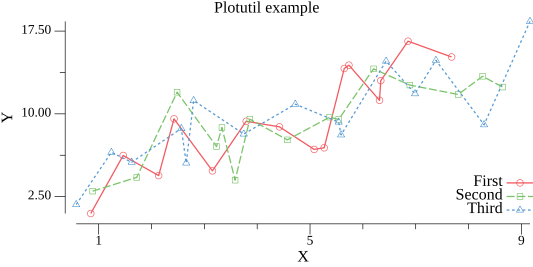

In [18]:
import (
    "bytes"
    "math/rand"

    "github.com/janpfeifer/gonb/gonbui"
    "gonum.org/v1/plot"
    "gonum.org/v1/plot/plotter"
    "gonum.org/v1/plot/plotutil"
    "gonum.org/v1/plot/vg"
)

// randomPoints returns some random x, y points.
func randomPoints(n int) plotter.XYs {
    pts := make(plotter.XYs, n)
    for i := range pts {
        if i == 0 {
            pts[i].X = rand.Float64()
        } else {
            pts[i].X = pts[i-1].X + rand.Float64()
        }
        pts[i].Y = pts[i].X + 10*rand.Float64()
    }
    return pts
}

func GonumPlotExample(width, height int, format string) []byte {
    rand.Seed(int64(0))

    p := plot.New()

    p.Title.Text = "Plotutil example"
    p.X.Label.Text = "X"
    p.Y.Label.Text = "Y"

    err := plotutil.AddLinePoints(p,
        "First", randomPoints(15),
        "Second", randomPoints(15),
        "Third", randomPoints(15))
    if err != nil {
        panic(err)
    }
    
    buf := bytes.NewBuffer(nil)
    writerTo, err := p.WriterTo(vg.Points(float64(width)), vg.Points(float64(height)), format)
    if err != nil {
        panic(err)
    }
    writerTo.WriteTo(buf)
    return buf.Bytes()
}

%%
gonbui.DisplayPng(GonumPlotExample(400, 200, "png"))

The version in SVG looks better though:

In [19]:
%%
gonbui.DisplaySvg(string(GonumPlotExample(400, 200, "svg")))

<?xml version="1.0"?>
<!-- Generated by SVGo and Plotinum VG -->
 
 
 
 Plotutil example 
 X 
 2 
 4 
 6 
 8 
 
 
 
 
 
 
 
 
 
 
 Y 
 
 5 
 10 
 15 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 First 
 
 
 Second 
 
 
 Third

### Plotting with [Plotly](https://plotly.com/)

[Plotly](https://plotly.com/) has really fancy plots, worth exploring for generating exquisite reports.

Currently supported using [`github.com/MetalBlueberry/go-plotly`](https://github.com/MetalBlueberry/go-plotly) library.

**Experimental**: but if you bump into any issues please report, and we'll try to fix it.

In [20]:
import (
    "github.com/janpfeifer/gonb/gonbui/plotly"
    grob "github.com/MetalBlueberry/go-plotly/graph_objects"
)

%%
fig := &grob.Fig{
    Data: grob.Traces{
        &grob.Bar{
            Type: grob.TraceTypeBar,
            X:    []float64{1, 2, 3},
            Y:    []float64{1, 2, 3},
        },
    },
    Layout: &grob.Layout{
        Title: &grob.LayoutTitle{
            Text: "A Figure Specified By Go Struct",
        },
    },
}
plotly.DisplayFig(fig)

### Desktop App Development with Fyne

If using a Jupyter-Lab ran with access to X11, one can also experiment with desktop UI programs. Let's try the [*Hello World*](https://developer.fyne.io/started/hello) from [Fyne](https://fyne.io/), a popular, high quality graphical application toolkit for Go.

> **Important Note**: Disabled by default: since this have many requirements, and won't run in a test environment. But feel free to
> copy&paste the code to a new cell and run it!

> **Note 1**: Fyne needs to link many C++ libraries, so the firt time this is used it takes a few minutes to compile everything. But
> afterwards it becomes immediate and interactive.

> **Note 2**: To compile it it requires some libraries present in the system. See [Fyne's Getting Started](https://developer.fyne.io/started/).

> **Note 3**: Remember to close the newly created small "Hello World!" window: GoNB is blocking while running a cell, and the cell only finishes to execute when the window is closed. Here we add a timeout just in case.

```go
import (
    "log"
    "time"

    "fyne.io/fyne/v2/app"
    "fyne.io/fyne/v2/widget"
)

%%
a := app.New()
w := a.NewWindow("Hello World")
go func() {
    <- time.Tick(10 * time.Second)
    log.Printf("Timed out, exiting...")
    os.Exit(1)
}()

w.SetContent(widget.NewLabel("Hello World!"))
w.ShowAndRun()
fmt.Println("Goodbye!")
```


## Init Functions

Since there is always only one definition per function name, it's not possible for
each cell to have it's own init() function.
Instead GoNB converts any function named `func init_something()` to `init()` before
compiling and executing the cells. 
This way each cell can create its own `func init_...()` and have it called at every
cell execution.

Example:

In [21]:
func init_a() {
    fmt.Println("init_a")
}
%%
fmt.Println("main")

init_a
main


In [22]:
func init_b() {
    fmt.Println("init_b")
}
%%
fmt.Println("main")

init_a
init_b
main


Now, we don't want to have `init_a` and `init_b` on all of our cells below. So we remove those definitions -- see how to manage memorized definitions using `%help`, in the "Managing Memorized Definitions" section, it's displayed at the end of the tutorial.

In [23]:
%rm init_a init_b

. removed func init_a
. removed func init_b


## Flags

The `%%` command can also be used to set arguments to the execution of the cell. This makes it easy to configure 
different runs of the same code using flags. This is something handy when testing or developing code that is shared
with a normal code that already used flags.

Also,`%%` not only wraps the code following it in a `func main() { ... }` but also automatically adds a call to `flag.Parse()`. 

Example:

In [24]:
import (
    "flag"
    "fmt"
)

var flagWho = flag.String("who", "", "Your name!")

%% --who=world
fmt.Printf("Hello %s!\n", *flagWho)

Hello world!


Alternatively one can also set the arguments for execution with `%args`, if not using `%%`, as in:

In [25]:
%args --who=Wally

func main() {
    flag.Parse()
    fmt.Printf("Where is %s?", *flagWho)
}

Where is Wally?

## Interacting with the DOM 

The package `gonbui/dom` allows one to manipulate the DOM in the browser in arbitrary ways. 

It is very useful if implementing new widgets. Things to check out for:

* `dom.TransientJavascript`: Executes Javascript in a transient cell output and then erases it (so it's not saved with the notebook).
* `dom.Append`: Appends HTML to a any element identified by an Id.
* `dom.SetInnerHtml` and `dom.GetInnerHtml`: Manipulate the `innerHTML` of any element.
* `dom.Persist`: Takes the `innerHTML` of a transient element, and then displays it normally with `gonbui.DisplayHtml`, so it can be saved with the notebook. Useful if using Javascript libraries (plotting for instance) that dyncamically generate content.

Check the library documentation for more! 

## Widgets

**GoNB** allows you to use the browser not only to output rich content (HTML, Widgets), but also interact with HTML UI elements.

It provides the `widgets` package with a few basic widgets for you to use, and a `gonbui/comms` package that you can use to create new widgets -- see `docs/FrontEndCommunication.md` file for more details on that.

Let's reuse our Sine curve plotting function below, and connect it to a slider. And then
create a button to stop the interaction when we are done.

(To allow this notebook to run automatically, we add a timeout -- if your playing with
the tutorial with a live Jupyter Notebook, feel free to change it or remove the timeout)

In [26]:
import (
    "github.com/janpfeifer/gonb/gonbui"
    "github.com/janpfeifer/gonb/gonbui/dom"
    "github.com/janpfeifer/gonb/gonbui/widgets"    
)

%%
freq := 5.5 // From 1.0 to 10.0, controlled by a slider

divId := dom.CreateTransientDiv()
slider := widgets.Slider(0, 100, 50).AppendTo(divId).Done()
freqHtml := fmt.Sprintf(`&nbsp;<span id="sin_freq" style="font-family: monospace; font-style: italic; font-size: small; border: 1px solid; border-style: inset; padding-right:5px;">%6.2f</span>&nbsp;`, freq)
dom.Append(divId, freqHtml)
button := widgets.Button("Ok").AppendTo(divId).Done()

// Initial plot.
htmlCellId := "sin_plot"+gonbui.UniqueId()
plotSvg := mgSinPlot(800, 240, freq)  // Defined in the cell above.
gonbui.UpdateHtml(htmlCellId, plotSvg)

// Listen to slider, button and a timeout timer.
sliderChan := slider.Listen().LatestOnly()
buttonChan := button.Listen()
loop:
for {
    select {
    case <- buttonChan.C:
        break loop
    case value := <-sliderChan.C:
        freq := 1.0 + 9.0 * float64(value) / 100.0
        dom.SetInnerText("sin_freq", fmt.Sprintf("%6.2f", freq))
        plotSvg = mgSinPlot(800, 240, freq)  // Defined in the cell above.
        gonbui.UpdateHtml(htmlCellId, plotSvg)
    case <- time.After(1000 * time.Millisecond):
        break loop
    }
}

// Erase transient UI and image and re-display it so it can be persisted.
gonbui.UpdateHtml(htmlCellId, "")
dom.Persist(divId)
gonbui.DisplayHtml(plotSvg)
gonbui.DisplayHtml("<p>Done.</p>")

5.50   Ok

<path vector-effect="non-scaling-stroke" d="M0.000000e+00,5.601382e+01 C1.131313e+00,5.917615e+01 4.525253e+00,6.903707e+01 6.787879e+00,7.498782e+01 C9.050505e+00,8.093858e+01 1.131313e+01,8.684513e+01 1.357576e+01,9.171837e+01 C1.583838e+01,9.659161e+01 1.810101e+01,1.010078e+02 2.036364e+01,1.042273e+02 C2.262626e+01,1.074468e+02 2.488889e+01,1.098504e+02 2.715152e+01,1.110355e+02 C2.941414e+01,1.122206e+02 3.167677e+01,1.123274e+02 3.393939e+01,1.113380e+02 C3.620202e+01,1.103486e+02 3.846465e+01,1.081460e+02 4.072727e+01,1.050991e+02 C4.298990e+01,1.020522e+02 4.525253e+01,9.780063e+01 4.751515e+01,9.305642e+01 C4.977778e+01,8.831222e+01 5.204040e+01,8.251441e+01 5.430303e+01,7.663388e+01 C5.656566e+01,7.075335e+01 5.882828e+01,6.409480e+01 6.109091e+01,5.777326e+01 C6.335354e+01,5.145171e+01 6.561616e+01,4.471971e+01 6.787879e+01,3.870460e+01 C7.014141e+01,3.268948e+01 7.240404e+01,2.668002e+01 7.466667e+01,2.168255e+01 C7.692929e+01,1.668509e+01 7.919192e+01,1.210871e+01 8.145455e+01,8.719788e+00 C8.371717e+01,5.330861e+00 8.597980e+01,2.728678e+00 8.824242e+01,1.348994e+00 C9.050505e+01,-3.068948e-02 9.276768e+01,-3.510054e-01 9.503030e+01,4.416857e-01 C9.729293e+01,1.234377e+00 9.955556e+01,3.233802e+00 1.018182e+02,6.105141e+00 C1.040808e+02,8.976480e+00 1.063434e+02,1.305924e+01 1.086061e+02,1.766972e+01 C1.108687e+02,2.228021e+01 1.131313e+02,2.796356e+01 1.153939e+02,3.376805e+01 C1.176566e+02,3.957254e+01 1.199192e+02,4.618449e+01 1.221818e+02,5.249668e+01 C1.244444e+02,5.880887e+01 1.267071e+02,6.556764e+01 1.289697e+02,7.164118e+01 C1.312323e+02,7.771472e+01 1.334949e+02,8.382115e+01 1.357576e+02,8.893792e+01 C1.380202e+02,9.405468e+01 1.402828e+02,9.878677e+01 1.425455e+02,1.023418e+02 C1.448081e+02,1.058968e+02 1.470707e+02,1.086950e+02 1.493333e+02,1.102679e+02 C1.515960e+02,1.118407e+02 1.538586e+02,1.123743e+02 1.561212e+02,1.117790e+02 C1.583838e+02,1.111838e+02 1.606465e+02,1.093896e+02 1.629091e+02,1.066966e+02 C1.651717e+02,1.040037e+02 1.674343e+02,1.000938e+02 1.696970e+02,9.562157e+01 C1.719596e+02,9.114936e+01 1.742222e+02,8.558608e+01 1.764848e+02,7.986334e+01 C1.787475e+02,7.414061e+01 1.810101e+02,6.758178e+01 1.832727e+02,6.128519e+01 C1.855354e+02,5.498859e+01 1.877980e+02,4.820972e+01 1.900606e+02,4.208375e+01 C1.923232e+02,3.595778e+01 1.945859e+02,2.976039e+01 1.968485e+02,2.452938e+01 C1.991111e+02,1.929837e+01 2.013737e+02,1.441523e+01 2.036364e+02,1.069769e+01 C2.058990e+02,6.980141e+00 2.081616e+02,3.988629e+00 2.104242e+02,2.224102e+00 C2.126869e+02,4.595761e-01 2.149495e+02,-2.865987e-01 2.172121e+02,1.105305e-01 C2.194747e+02,5.076597e-01 2.217374e+02,2.095049e+00 2.240000e+02,4.606878e+00 C2.262626e+02,7.118706e+00 2.285253e+02,1.085197e+01 2.307879e+02,1.518150e+01 C2.330505e+02,1.951104e+01 2.353131e+02,2.494876e+01 2.375758e+02,3.058408e+01 C2.398384e+02,3.621940e+01 2.421010e+02,4.271863e+01 2.443636e+02,4.899343e+01 C2.466263e+02,5.526822e+01 2.488889e+02,6.206051e+01 2.511515e+02,6.823286e+01 C2.534141e+02,7.440521e+01 2.556768e+02,8.068743e+01 2.579394e+02,8.602753e+01 C2.602020e+02,9.136762e+01 2.624646e+02,9.639699e+01 2.647273e+02,1.002734e+02 C2.669899e+02,1.041499e+02 2.692525e+02,1.073317e+02 2.715152e+02,1.092861e+02 C2.737778e+02,1.112406e+02 2.760404e+02,1.121987e+02 2.783030e+02,1.120000e+02 C2.805657e+02,1.118013e+02 2.828283e+02,1.104224e+02 2.850909e+02,1.080942e+02 C2.873535e+02,1.057659e+02 2.896162e+02,1.022130e+02 2.918788e+02,9.803041e+01 C2.941414e+02,9.384783e+01 2.964040e+02,8.854103e+01 2.986667e+02,8.299868e+01 C3.009293e+02,7.745633e+01 3.031919e+02,7.102311e+01 3.054545e+02,6.477631e+01 C3.077172e+02,5.852951e+01 3.099798e+02,5.173052e+01 3.122424e+02,4.551788e+01 C3.145051e+02,3.930524e+01 3.167677e+02,3.294437e+01 3.190303e+02,2.750047e+01 C3.212929e+02,2.205656e+01 3.235556e+02,1.688593e+01 3.258182e+02,1.285443e+01 C3.280808e+02,8.822935e+00 3.303434e+02,5.453899e+00 3.326061e+02,3.311494e+00 C3.348687e+02,1.169089e+00 3.371313e+02,4.144833e-15 3.

Done.

### User Input

There are different ways to provide input to a program in GoNB. We list them below and introduce a new one:

1. Simply define constants or variables in the cell and use them. The cell itself is a good way to enter input.
2. Add flags, and pass the values of flags after the `%%` command. For instance `%% --x=10` will run your cell with the flag `x` set to 10. This is handy for instance to test a function with different values, each one in a different cell.
3. Read the input from an external file. One can edit the file in Jupyter or another text editor. It's easy to set `os.Stdin` to the desired file.
4. Use HTML widgets (see `gonbui/widgets` package, described above).
5. Jupyter Notebooks also provides a form of input request, where it displays an in-place text box. The `gonbui` package has a function to do that, the results of which can be read in from the `stdin` afterwards. See the following example:

```go
import (
    "fmt"
    "github.com/janpfeifer/gonb/gonbui"
)

%%
gonbui.RequestInput("Tell me a number: ", false)
var x int
_, err := fmt.Scan(&x)
if err != nil { panic(err) }
fmt.Printf("The number you typed was %d\n", x)

gonbui.RequestInput("Tell me a secret: ", true)
var secret string
_, err = fmt.Scan(&secret)
if err != nil { panic(err) }
fmt.Printf("Shh! Your secret was %q\n", secret)
```

The output would be something like:

```
Tell me a number:  42
The number you typed was 42
Tell me a secret:  ······
Shh! Your secret was "I🧡GoNB!"
```

> **Note**: Not executed by default because it breaks the automatic tests, but try it out on a new cell!

## Executing Shell Commands

There are two variations to execute shell commands. They differ only on the directory
from where they are executed.

* `!` prefix executes what comes next should be executed as a shell command, on the same directory
  where the kernel is executed -- typically the same directory where the notebook files is saved.


In [27]:
!go version
!pwd ; ls -l

go version go1.24.2 linux/amd64
/home/janpf/Projects/gonb/examples
total 332
-rw-rw-r-- 1 janpf janpf 108240 Sep 23  2024 google_colab_demo.ipynb
drwxr-xr-x 3 janpf janpf   4096 May 19 11:44 tests
-rw-r--r-- 1 janpf janpf 209674 May 19 11:46 tutorial.ipynb
-rw-r--r-- 1 janpf janpf  10090 Dec 15  2023 wasm_demo.ipynb


* `!*` prefix executes what comes next as a shell command, on the temporary directory used 
  to compile the *Go* program when executing the cells. This includes the `go.mod` file, that
  can be manipulated for special use cases, like importing a specific version of a module, 
  or to `redirect` a module to a local directory for development (see `Replace` section below)
  
Example:

In [28]:
!*pwd ; ls -l

/tmp/gonb_4387b406
total 14736
-rw-r--r-- 1 janpf janpf     1359 May 19 11:48 go.mod
-rwxr-xr-x 1 janpf janpf 15068548 May 19 11:48 gonb_4387b406
srwxr-xr-x 1 janpf janpf        0 May 19 11:47 gopls_socket
-rw-r--r-- 1 janpf janpf     7811 May 19 11:48 go.sum
-rw-r--r-- 1 janpf janpf     6177 May 19 11:48 main.go


You can also use a `\` at the end of the line to extend the shell command to multiple lines.

Example:

In [29]:
!((ii=0)) ;\
while ((ii < 5)) ; do \
  printf "\rCounting: ${ii} ..." ;\
  sleep 1;\
  ((ii+=1));\
done;\
echo

Counting: 4 ...


If some shell program requires some input from the user, you can precede it with a `%with_inputs` or `%with_password` (for hidden input) and it will open a text field for typing some arbitrary text input. Example:

```shell
%with_password
!sudo -S apt update
```

## Debugging A Cell

While **GoNB** doesn't (yet) talk the debug protocol with JupyterLab, it's easy to start a GUI debugger
from a cell, if being executed on the same machine as the browser.

The common Go debugger recommendation is [delve](https://github.com/go-delve/delve), and in particular its front-end
[gdlv](https://github.com/aarzilli/gdlv). And to make it simpler **GoNB** includes a small wrapper script 
[`ndlv`](https://github.com/janpfeifer/gonb/blob/main/cmd/ndlv/ndlv) to
set the directory and program name to the last cell executed. Copy or link that script somewhere in your `PATH`
(maybe `${HOME}/bin` if you have such directory set up).

To open the debugger, after executing a cell you want to debug, you create and execute a new cell with this single shell command:

```
!ndlv
```


## Environment Variables

For convenience, **GoNB** defines the following environment variables -- available for the shell scripts (`!` and `!*`) and for the _Go_ cells:

* `GONB_DIR`: the directory where commands are executed from. This can be changed with `%cd`.
* `GONB_TMP_DIR`: the directory where the temporary Go code, with the cell code, is stored and compiled. This is the directory where `!*` scripts are executed. It only changes when a kernel is restarted, and a new temporary directory is created.
* `GONB_PIPE`: is the _named pipe_ directory used to communicate rich content (HTML, images) to the kernel. Only available for _Go_ cells, and a new one is created at every execution. This is used by the `gonbui` functions described above, and doesn't need to be accessed directly.

## Tests and Benchmarks

**GoNB** allows also executing the cell with `go test`, to demo or debug tests and benchmarks. For that just mark the cell with `%test` and if no other parameters are given, it will run the tests and benchmarks defined in the current cell.

If it is the only command in the cell, it will run all tests defined so far. 

In [30]:
import "github.com/stretchr/testify/require"

func TestIncr(t *testing.T) {
    require.Equal(t, 2, incr(1))    
}

func BenchmarkIncr(b *testing.B) {
    for i := 0; i < b.N; i++ {
        _ = incr(i)
    }
}

%test

=== RUN   TestIncr
--- PASS: TestIncr (0.00s)
goos: linux
goarch: amd64
pkg: gonb_4387b406
cpu: AMD Ryzen 9 9950X3D 16-Core Processor          
BenchmarkIncr
BenchmarkIncr-32    	1000000000	         0.1811 ns/op
PASS


Alternatively, you can provide extra flags that are passed to the test binary. For instance, to execute all benchmarks defined so far, use:

```
%test -test.bench=. -test.run=Bechmark
```

## Developing Go libraries with a notebook: `go.mod` and `go.work`

*GoNB* uses `go.mod` and understands `go.work` -- but won't create it by default.

### "Replace" modules in `go.mod`

Using the `!*` command above we can easily "replace" a module to a local directory. This can be very handy
for developing a library in a powerful IDE on the side, and using the *GoNB* notebook to execute tests
and experiments. Changes in the library (in the IDE) when saved immediate take effect on the next cell execution.


The accompaining library *gonbui* was implemented mostly in this fashion using a notebook, that started with:

```
!*go mod edit -replace github.com/janpfeifer/gonb=/home/janpf/Projects/gonb
```

Check out the results with:

```
!*cat go.mod
```

In [31]:
!*go mod edit -replace "github.com/janpfeifer/gonb=${HOME}/Projects/gonb"
!*cat go.mod

module gonb_4387b406

go 1.24.2

require (
	github.com/MetalBlueberry/go-plotly v0.5.0
	github.com/ajstarks/svgo v0.0.0-20211024235047-1546f124cd8b
	github.com/benc-uk/gofract v0.0.0-20230120162050-a6f644f92fd6
	github.com/erkkah/margaid v0.1.1-0.20230128143048-d60b2efd2f5a
	github.com/janpfeifer/gonb v0.10.11
	github.com/schollz/progressbar/v3 v3.18.0
	github.com/stretchr/testify v1.9.0
	golang.org/x/exp v0.0.0-20250106191152-7588d65b2ba8
	gonum.org/v1/plot v0.16.0
)

require (
	codeberg.org/go-fonts/liberation v0.5.0 // indirect
	codeberg.org/go-latex/latex v0.1.0 // indirect
	codeberg.org/go-pdf/fpdf v0.10.0 // indirect
	git.sr.ht/~sbinet/gg v0.6.0 // indirect
	github.com/campoy/embedmd v1.0.0 // indirect
	github.com/davecgh/go-spew v1.1.1 // indirect
	github.com/go-logr/logr v1.4.2 // indirect
	github.com/gofrs/uuid v4.4.0+incompatible // indirect
	github.com/golang/freetype v0.0.0-20170609003504-e2365dfdc4a0 // indirect
	github.com/lucasb-eyer/go-colorful v1.0.3 // indirect
	githu

### "Use" modules in `go.work`

Another way to refer to modules that are being co-developed in local file is using [Go workspaces](https://go.dev/doc/tutorial/workspaces).
                                                                                                   
In **GoNB**, a convenient way to achive this is by first creating a `go.work` and then selecting the modules to be use from the local disk. Example:                                                                                           

In [32]:
!*rm -f go.work && go work init && go work use . "${HOME}/Projects/gonb"
%goworkfix

	- Replace rule for module "github.com/janpfeifer/gonb" to local directory "/home/janpf/Projects/gonb" already exists.


> **Note**:
> - **GoNB** uses `go get` to automatically fetch missing imports.
>   Unfortunately `go get` doesn't handle `go.work` `use` definitions.
>   The special command `%goworkfix` handles that by adding a `replace` entry in `go.mod` for
>   all modules pointed to by `go.work`.
> - One can use the env variable `GONB_DIR` to refer to the current kernel directory (changed with `%cd`).

### Tracked directories

**GoNB** tracks for changes in local files in target directories of `replace` rules in `go.mod` or `use` rules in `go.work`. This way auto-complete and contextual help stay up-to-date with changes on local files you may be editing on a separate editor.

See `%track` and `%untrack` to list and control tracking. For instance, in our tutorial, this is what **GoNB** is tracking:

In [33]:
%track

List of files/directories being tracked: 
 
 /home/janpf/Projects/gonb 
 /home/janpf/Projects/gonb/cache 
 /home/janpf/Projects/gonb/cmd/nbexec 
 /home/janpf/Projects/gonb/common 
 /home/janpf/Projects/gonb/gonbui 
 /home/janpf/Projects/gonb/gonbui/comms 
 /home/janpf/Projects/gonb/gonbui/dom 
 /home/janpf/Projects/gonb/gonbui/plotly 
 /home/janpf/Projects/gonb/gonbui/protocol 
 /home/janpf/Projects/gonb/gonbui/wasm 
 /home/janpf/Projects/gonb/gonbui/widgets 
 /home/janpf/Projects/gonb/internal/comms 
 /home/janpf/Projects/gonb/internal/dispatcher 
 /home/janpf/Projects/gonb/internal/goexec 
 /home/janpf/Projects/gonb/internal/goexec/goplsclient 
 /home/janpf/Projects/gonb/internal/jpyexec 
 /home/janpf/Projects/gonb/internal/kernel 
 /home/janpf/Projects/gonb/internal/nbtests 
 /home/janpf/Projects/gonb/internal/specialcmd 
 /home/janpf/Projects/gonb/internal/version 
 /home/janpf/Projects/gonb/internal/websocket 
 /home/janpf/Projects/gonb/version

### Custom `go build` flags

Sometimes it can be desirable to change the Go flags used to build the cells being executed.
For instance to check for coverage, or enable race condition detection, etc.

**GoNB** supports this in two ways:

1. You can tell **GoNB** to use arbitrary `go build` flags with `%goflags <values ...>`. `%goflags` without any values displays current settings, and `%goflags ""` will reset to the default (no extra flags).
2. In some cases it's not that one wants **GoNB** to build the binary with the flags, but simply run `go build ...` to see the results. This is supported by simply running `!*go build ...`, which is conveniently executed (the `!*` prefix) in the temporary directory where the cells code maintained by **GoNB** is located (in a `main.go`). E.g.: To look at optimization decisions, use `!*go build -gcflags=-m`.

See an example in the `examples/tests/gcflags.ipynb` file, which is used as an integration test.

## More ... and Help

Some other features:

* **Errors reported** by the Go compiler are parsed and a **_mouse-over_ context is displayed**. This facilitates understanding the error, since the line numbers reported by Go are not the same as in the cell being executed.
* **Contextual Help**: can be activated with **"Shift+Tab""** (floating note) or **"Control+I"** (for a separate sub-window). Notice it may be slow if some new import needs to be fetched -- consider executing once some code with the imports before using the contextual help.

The library is new, and there is still development going on, with still some features in the pipeline (more on the displaying side, auto-complete). For those
who enjoy coding, help in improving *GoNB* is very welcome!

Finally, there is also the `%help` command, which lists all the currently supported features:

In [34]:
%help

## GoNB Help Page

**GoNB** is a Go kernel that compiles and executes on-the-fly Go code.

When executing a cell, **GoNB** will save the cell contents (except non-Go commands see
below) into a `main.go` file, compile and execute it.

It also saves any global declarations (imports, functions, types, variables, constants)
and reuse them at the next cell execution -- so you can define a function in one
cell, and reuse in the next one. Just the `func main()` is not reused.

A `hello world` example would look like:

```go
func main() {
    fmt.Printf(`Hello world!\n`);
}

```

But to avoid having to type `func main()` all the time, you can use `%%` and everything
after is wrapped inside a `func main() { ... }`. 
So our revised `hello world` looks like:

```go
%%
fmt.Printf(`Hello world!\n`)

```


### Init Functions -- `func init()`

Since there is always only one definition per function name, it's not possible for
each cell to have its own init() function. 
Instead, **GoNB** converts any function named `init_something()` to `init()` before 
compiling and executing. 
This way each cell can create its own `init_...()` and have it called at every cell execution.


### Special non-Go Commands

- `%% [<args...>]` or `%main [<args...>]`: Marks the lines as follows to be wrapped in a `func main() {...}` during
  execution. A shortcut to quickly execute code. It also automatically includes `flag.Parse()`
  as the very first statement. Anything after`%%` or `%main` are taken as arguments
  to be passed to the program -- it resets previous values given by `%args`.
- `%args <args...>`: Sets arguments to be passed when executing the Go code. This allows one to
  use flags as a normal program. Notice that if a value after `%%` or `%main` is given, it will
  overwrite the values here.
- `%exec <my_func> [<args...>]`: this will call the function `my_func()`, and optionally set the program arguments.
  Behind the scenes it creates a trivial `func main()` that parses the flags and calls `my_func()` (without any
  parameters or return values).
- `%autoget` and `%noautoget`: Default is `%autoget`, which automatically does `go get` for
  packages not yet available.
- `%cd [<directory>]`: Change current directory of the Go kernel, and the directory from where
  the cells are executed. If no directory is given it reports the current directory.
- `%env VAR value`: Sets the environment variable VAR to the given value. These variables
  will be available both for Go code and for shell scripts.
- `%goflags <values...>`: Configures list of extra arguments to pass to `go build` when compiling the
  code for execution of a cell.
  If no values are given, it simply shows the current setting.
  To reset its value, use `%goflags """`.
  See example on how to use this in the [tutorial](https://github.com/janpfeifer/gonb/blob/main/examples/tutorial.ipynb). 
- `%with_inputs`: will prompt for inputs for the next shell command. Use this if
  the next shell command (`!`) you execute reads the stdin. Jupyter will require
  you to enter one last value after the shell script executes.
- `%with_password`: will prompt for a password passed to the next shell command.
  Do this is if your next shell command requires a password.
- `%capture [-a] <file_path>` will make a copy of all **cell execution output** to the given file. By default
  it overwrites the file contents each time the cell is executed. Use `-a` instead to append to the file.
  It works only for the current cell. See also `%%writefile` to write files with a specific content.
  It doesn't work with `%wasm` cells.
- `%version` prints out **GoNB**'s version.

**Notes**: 

1. The special commands below can be used in the start of the line as is, or prefixed by a `//gonb:`, which may be easier
on some IDEs if editing the code externally (since these special commands are not proper Go). 
So `//gonb:%%` is the same as `%%` 
2. All these commands are executed **before** any Go code in the same cell.


### Managing Memorized Definitions

- `%list` (or `%ls`): Lists all memorized definitions (imports, constants, types, variables and
  functions) that are carried from one cell to another.
- `%remove <definitions>` (or `%rm <definitions>`): Removes (forgets) given definition(s). Use as key the
  value(s) listed with `%ls`.
- `%reset [go.mod]` clears all memorized definitions (imports, constants, types, functions, etc.)
  as well as re-initializes the `go.mod` file. 
  If the optional `go.mod` parameter is given, it will re-initialize only the `go.mod` file -- 
  useful when testing different set up of versions of libraries.


### Executing Shell Commands

- `!<shell_cmd>`: executes the given command on a new shell. It makes it easy to run
  commands on the kernels box, for instance to install requirements, or quickly
  check contents of directories or files. Lines ending in `\` are continued on
  the next line -- so multi-line commands can be entered. But each command is
  executed in its own shell, that is, variables and state is not carried over.
- `!*<shell_cmd>`: same as `!<shell_cmd>` except it first changes directory to
  the temporary directory used to compile the go code -- the latest execution
  is always saved in the file `main.go`. It's also where the `go.mod` file for
  the notebook is created and maintained. Useful for manipulating `go.mod`,
  for instance to get a package from some specific version, something
  like `!*go get github.com/my/package@v3`.

Notice that when the cell is executed, first all shell commands are executed, and only after that, if there is
any Go code in the cell, it is executed.

### Running a Debugger

While **GoNB** doesn't (yet) talk the debug protocol with JupyterLab, it's easy to start a GUI debugger
from a cell, if being executed on the same machine as the browser.

The common Go debugger recommendation is [delve](https://github.com/go-delve/delve), and in particular its front-end
[gdlv](https://github.com/aarzilli/gdlv). And to make it simpler **GoNB** includes a small wrapper script 
[`ndlv`](https://github.com/janpfeifer/gonb/blob/main/cmd/ndlv/ndlv) to
set the directory and program name to the last cell executed. Copy or link that script somewhere in your `PATH`
(maybe `${HOME}/bin` if you have such directory set up).

To open the debugger, after executing a cell you want to debug, you create and execute a new cell with this single shell command:

```
!ndlv
```

### Tracking of Go Files In Development:

A convenient way to develop programs or libraries in **GoNB** is to use replace
rules in **GoNB**'s `go.mod` to your program or library being developed and test
your program from **GoNB** -- see the 
[Tutorial]((https://github.com/janpfeifer/gonb/blob/main/examples/tutorial.ipynb))'s
section "Developing Go libraries with a notebook" for different ways of achieving this.

To manipulate the list of files tracked for changes:

- `%track [file_or_directory]`: add file or directory to list of tracked files,
  which are monitored by **GoNB** (and 'gopls') for auto-complete or contextual help.
  If no file is given, it lists the currently tracked files.
- `%untrack [file_or_directory][...]`: remove file or directory from list of tracked files.
  If suffixed with `...` it will remove all files prefixed with the string given (without the
  `...`). If no file is given, it lists the currently tracked files.


### Environment Variables

For convenience, **GoNB** defines the following environment variables -- available for the shell
scripts (`!` and `!*`) and for the Go cells:

- `GONB_DIR`: the directory where commands are executed from. This can be changed with `%cd`.
- `GONB_TMP_DIR`: the directory where the temporary Go code, with the cell code, is stored
  and compiled. This is the directory where `!*` scripts are executed. It only changes when a kernel
  is restarted, and a new temporary directory is created.
- `GONB_PIPE`: is the _named pipe_ directory used to communicate rich content (HTML, images)
  to the kernel. Only available for _Go_ cells, and a new one is created at every execution.
  This is used by the `**GoNB**ui`` functions described above, and doesn't need to be accessed directly.
- `GONB_VERSION`: Version of this *GoNB* build.
- `GONB_GIT_COMMIT`: Git commit hash for this *GoNB* build -- notice it doesn't account for any modifications that
  may have been made and not committed.
- `GONB_JUPYTER_KERNEL_ID`: the unique id assigned by Jupyter to this kernel.
  It's used to build some of the API paths to the JupyterServer.
  If it's not set, GoNB was not able to parse it from the kernel file path.
- `GONB_JUPYTER_ROOT`: the path to the Jupyter root directory, if GONB managed to read it (depends on the architecture).
  This can be used to construct URLs to static file contents (images, javascript, etc.) served by Jupyter: 
  one can use `src="/file/...<path under GONB_JUPYTER_ROOT>..."`.

### Widgets

The package `gonbui/widgets` offers widgets that can be used to interact in a more
dynamic way, using the HTML element in the browser. E.g.: buttons, sliders.

It's not necessary to do anything, but, to help debug the communication system
with the front-end, **GoNB** offers a couple of special commands:

- `%widgets` - install the javascript needed to communicate with the frontend.
  This is usually not needed, since it happens automatically when using Widgets.
- `%widgets_hb` - send a _heartbeat_ signal to the front-end and wait for the
  reply.
  Used for debugging only.

### Writing for WASM (WebAssembly) (Experimental)

**GoNB** can also compile to WASM and run in the notebook. This is experimental, and likely to change
(feedback is very welcome), and can be used to write interactive widgets in Go, in the notebook.

When a cell with `%wasm` is executed, a temporary directory is created under the Jupyter root directory
called `jupyter_files/<kernel unique id>/` and the cell is compiled to a wasm file and put in that 
directory.

Then **GONB** outputs the javascript needed to run the compiled wam.

In the Go code, the following extra constants/variables are created in the global namespace, and can be used
in your Go code:

- `GonbWasmDir`, `GonbWasmUrl`: the directory and url (served by Jupyter) where the generated `.wasm` files are read.
  Potentially, the user can use it to serve other files.
  These are unique for the kernel, but shared among cells.
- `GonbWasmDivId`: When a `%wasm` cell is executed, an empty `<div id="<unique_id>"></div>`
  is created with a unique id -- every cell will have a different one.
  This is where the Wasm code can dynamically create content.

The following environment variables are set when `%wasm` is created:

- `GONB_WASM_SUBDIR`, `GONB_WASM_URL`: the directory and url (served by Jupyter) where the generated `.wasm` files are read.
  Potentially, the user can use it to serve other files.
  These environment variables are available for shell scripts (`!...` and `!*...` special commands) and non-wasm 
  programs if they want to serve different files from there.


### Writing Tests and Benchmarks

If a cell includes the `%test` command (anywhere in cell), it is compiled with `go test`
(as opposed to `go build`).
This can be very useful both to demonstrate tests, or simply help develop/debug them in a notebook.

If `%test` is given without any flags, it uses by default the flags `-test.v` (verbose) and `-test.run` defined
with the list of the tests defined in the current cell. 
That is, it will run only the tests in the current cell. 
Also, if there are any benchmarks in the current cell, it appends the flag `-test.bench=.` and runs the benchmarks
defined in the current cell.

Alternatively one can use `%test <flags>`, and the `flags` are passed to the binary compiled with `go test`. 
Remember that test flags require to be prefixed with `test.`. 
So for a verbose output, use `%test -test.v`. 
For benchmarks, run `%test -test.bench=. -test.run=Benchmark`. 

See examples in the [`gotest.ipynb` notebook here](https://github.com/janpfeifer/gonb/blob/main/examples/tests/gotest.ipynb).


### Cell Magic

The following are special commands that change how the cell is interpreted, so they are prefixed with `%%` (two '%'
symbols). They try to follow [IPython's Cell Magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cell-magics).

They must always appear as the first line of the cell.

The contents in the cells are not assumed to be Go, so auto-complete and contextual help are disabled in those cells.

#### `%%writefile`

```
%%writefile [-a] <filePath>
```

Write contents of the cell (except the first line with the '%%writefile') to the given `<filePath>`. If `-a` is given
it will append the cell contents to the file.

This can be handy if for instance the notebook needs to write a configuration file, or simply to dump the code inside
the cell into some file.

File path passes through a tilde (`~`) expansion to the user's home directory, as well as environment variable substitution (e.g.: `${HOME}` or `$MY_DIR/a/b`).

See also `%capture` to instead write the output of the execution of the cell to a file.

### `%%script`, `%%bash` and `%%sh`

```
%%script <command>
```

Execute `<command>` and feed it (`STDIN`) with the contents of the cell. The `%%bash` and `%%sh` magic is an alias to `%%script bash` and `%%script sh` respectively.

Generally, a convenient way to run larger scripts.


### Other

- `%goworkfix`: work around 'go get' inability to handle 'go.work' files. If you are
  using 'go.work' file to point to locally modified modules, consider using this. It creates
  'go mod edit --replace' rules to point to the modules pointed to the 'use' rules in 'go.work'
  file.
  It overwrites/updates 'replace' rules for those modules, if they already exist. See 
  [tutorial](https://github.com/janpfeifer/gonb/blob/main/examples/tutorial.ipynb) for an example.

### Links

- [github.com/janpfeifer/gonb](https://github.com/janpfeifer/gonb) - GitHub page.
- [Tutorial](https://github.com/janpfeifer/gonb/blob/main/examples/tutorial.ipynb).
- [go.dev](https://pkg.go.dev/github.com/janpfeifer/gonb) package reference.